In [7]:
%matplotlib inline
import numpy as np
import pandas as pd
import sys
import math 
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import model_selection
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV,ElasticNetCV
from pyentrp import entropy as pyent
import EntropyHub as EH
import neurokit2 as nk
import random
import sampen
import requests
import io
from pprint import pprint
import os
from sklearn import preprocessing
from datetime import datetime, timedelta
from typing import List
import itertools
from datetime import datetime
import itertools
from sklearn.tree import DecisionTreeRegressor

In [3]:
c_01 = pd.read_csv("hpq_20230502133237.log", names=["date", "size"])
c_01

,date,size
0,2023-05-02T13:32:38+00:00,16
1,2023-05-02T13:32:39+00:00,16
2,2023-05-02T13:32:40+00:00,16
3,2023-05-02T13:32:41+00:00,16
4,2023-05-02T13:32:42+00:00,16
...,...,...
1159,2023-05-02T13:54:11+00:00,6
1160,2023-05-02T13:54:12+00:00,6
1161,2023-05-02T13:54:13+00:00,6
1162,2023-05-02T13:54:15+00:00,6


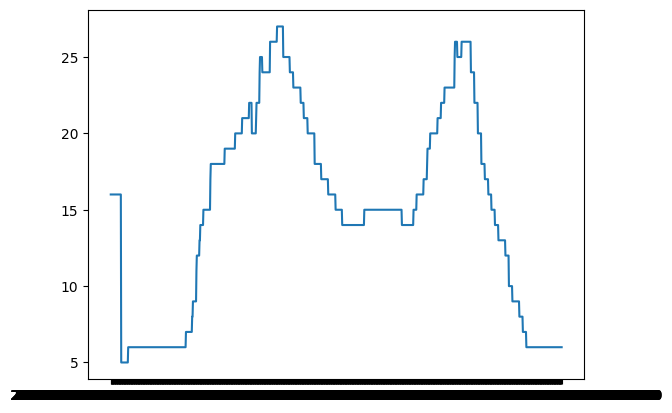

In [4]:
plt.plot(c_01["date"], c_01["size"])

In [5]:
def parse(path: str) -> pd.DataFrame:
    # CSVから読み取る
    try:
        df = pd.read_csv(path,  delimiter='\t', header=None, names=[ 'c{0:02d}'.format(i) for i in range(10) ])
    except Exception as e:
        raise(e)
    df_target = df.to_numpy()

    # いい感じに整形
    requests = pd.DataFrame([{"date": datetime.fromtimestamp(float(d[4])/1000), "status": d[6], "count": 1} for d in df_target if (d[0] == "REQUEST" and not math.isnan(float(d[4])) )])
    if len(requests) == 0:
        return pd.DataFrame([])

    # 1秒ごとにサマる
    grouped1 = requests.groupby([pd.Grouper(key=("status")),pd.Grouper(key=("date"), freq="S")]).sum().reset_index()

    # 全部同じ数は困るので乱数を入れておく
    for x in range(len(grouped1)):
        grouped1.iat[x, 2] += np.random.rand() * sys.float_info.epsilon

    return grouped1

In [6]:
df_01 = parse("./worldcap+simulation.log")

/var/folders/zk/cf948rq56631k5dgzn62fkjm0000gn/T/ipykernel_26509/600845077.py:4: DtypeWarning: Columns (2,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path,  delimiter='\t', header=None, names=[ 'c{0:02d}'.format(i) for i in range(10) ])


In [8]:
def reg_tree() -> DecisionTreeRegressor:
    X = [
        [60],
        [100],
        [140],
        [175],
        [210],
        [255],
        [300],
        [330],
        [360],
        [390],
        [420],
        [460],
        [500],
        [540],
        [580],
        [610],
        [640],
        [670],
        [700],
        [730],
        [760],
        [790],
        [820],
        [850],
        [880],
        [910],
        [940],
        [970],
        [1000],
        [1030],
        [1060],
    ]

    y = [
        4,
        5,
        6,
        7,
        8,
        9,
        10,
        11,
        12,
        13,
        14,
        15,
        16,
        17,
        18,
        19,
        20,
        21,
        22,
        23,
        24,
        25,
        26,
        27,
        28,
        29,
        30,
        31,
        32,
        33,
        34,
    ]

    return DecisionTreeRegressor().fit(X, y)

In [9]:
replaced_c_01 = c_01
replaced_c_01["date"] = pd.to_datetime(c_01["date"], utc = False) + pd.to_timedelta(9, unit='h')
replaced_c_01

,date,size
0,2023-05-02 22:32:38+00:00,16
1,2023-05-02 22:32:39+00:00,16
2,2023-05-02 22:32:40+00:00,16
3,2023-05-02 22:32:41+00:00,16
4,2023-05-02 22:32:42+00:00,16
...,...,...
1159,2023-05-02 22:54:11+00:00,6
1160,2023-05-02 22:54:12+00:00,6
1161,2023-05-02 22:54:13+00:00,6
1162,2023-05-02 22:54:15+00:00,6


In [12]:
replaced_df_01 = df_01[df_01["status"] != "KO"]
replaced_df_01["date"] = pd.to_datetime(df_01["date"], utc=True)
replaced_df_01

/var/folders/zk/cf948rq56631k5dgzn62fkjm0000gn/T/ipykernel_26509/3566697410.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  replaced_df_01["date"] = pd.to_datetime(df_01["date"], utc=True)


,status,date,count
5,OK,2023-05-02 22:32:55+00:00,47
6,OK,2023-05-02 22:32:56+00:00,126
7,OK,2023-05-02 22:32:57+00:00,116
8,OK,2023-05-02 22:32:58+00:00,126
9,OK,2023-05-02 22:32:59+00:00,114
...,...,...,...
1261,OK,2023-05-02 22:53:51+00:00,138
1262,OK,2023-05-02 22:53:52+00:00,127
1263,OK,2023-05-02 22:53:53+00:00,153
1264,OK,2023-05-02 22:53:54+00:00,141


In [13]:
merged_01 = pd.merge(replaced_df_01, replaced_c_01, left_on="date", right_on="date")
merged_01

,status,date,count,size
0,OK,2023-05-02 22:32:55+00:00,47,16
1,OK,2023-05-02 22:32:56+00:00,126,16
2,OK,2023-05-02 22:32:57+00:00,116,16
3,OK,2023-05-02 22:32:58+00:00,126,16
4,OK,2023-05-02 22:32:59+00:00,114,16
...,...,...,...,...
1127,OK,2023-05-02 22:53:51+00:00,138,6
1128,OK,2023-05-02 22:53:52+00:00,127,6
1129,OK,2023-05-02 22:53:53+00:00,153,6
1130,OK,2023-05-02 22:53:54+00:00,141,6


In [18]:
merged_02 = merged_01
merged_02["expected_size"] = merged_01["count"].map(lambda x: reg_tree().predict([[x]])[0])
merged_02["diff"] = abs(merged_02["size"] - merged_02["expected_size"])
merged_02


,status,date,count,size,expected_size,diff
0,OK,2023-05-02 22:32:55+00:00,47,16,4.0,12.0
1,OK,2023-05-02 22:32:56+00:00,126,16,6.0,10.0
2,OK,2023-05-02 22:32:57+00:00,116,16,5.0,11.0
3,OK,2023-05-02 22:32:58+00:00,126,16,6.0,10.0
4,OK,2023-05-02 22:32:59+00:00,114,16,5.0,11.0
...,...,...,...,...,...,...
1127,OK,2023-05-02 22:53:51+00:00,138,6,6.0,0.0
1128,OK,2023-05-02 22:53:52+00:00,127,6,6.0,0.0
1129,OK,2023-05-02 22:53:53+00:00,153,6,6.0,0.0
1130,OK,2023-05-02 22:53:54+00:00,141,6,6.0,0.0


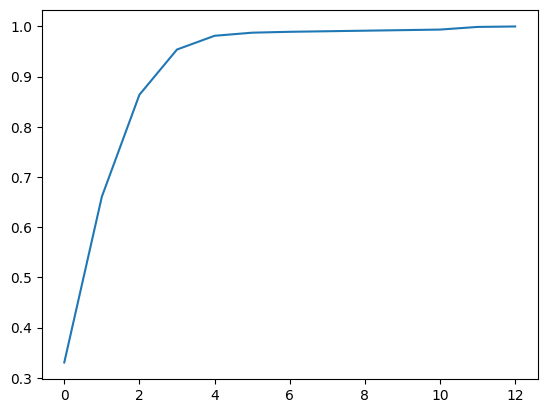

In [19]:
# CDFの計算
pmf = merged_02['diff'].value_counts(normalize=True).sort_index()
cdf = np.cumsum(pmf)

plt.plot(cdf)

In [21]:
merged_02['diff'].value_counts()

1.0     374
0.0     374
2.0     230
3.0     102
4.0      31
5.0       7
11.0      6
10.0      5
6.0       2
12.0      1
Name: diff, dtype: int64

In [20]:
pmf

0.0     0.330389
1.0     0.330389
2.0     0.203180
3.0     0.090106
4.0     0.027385
5.0     0.006184
6.0     0.001767
10.0    0.004417
11.0    0.005300
12.0    0.000883
Name: diff, dtype: float64

In [26]:
cdf

0.0     0.330389
1.0     0.660777
2.0     0.863958
3.0     0.954064
4.0     0.981449
5.0     0.987633
6.0     0.989399
10.0    0.993816
11.0    0.999117
12.0    1.000000
Name: diff, dtype: float64

In [28]:
cdf.index

Float64Index([0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 10.0, 11.0, 12.0], dtype='float64')

In [30]:
cdf.to_numpy()

array([0.33038869, 0.66077739, 0.8639576 , 0.9540636 , 0.98144876,
       0.98763251, 0.98939929, 0.99381625, 0.99911661, 1.        ])

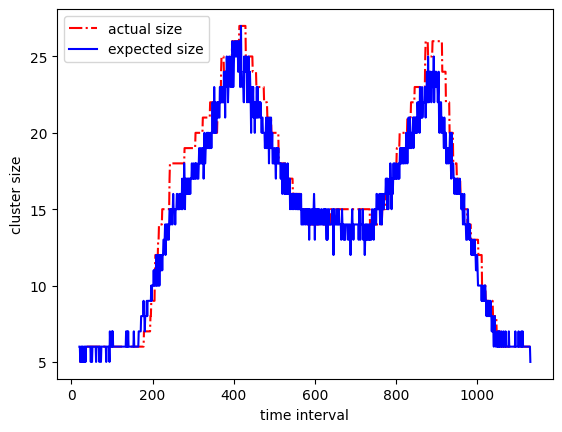

In [25]:
plt.xlabel(xlabel="time interval")
plt.ylabel(ylabel="cluster size")

plt.plot([k for k, v in enumerate(merged_02["date"])][20:], merged_02["size"][20:], color="red", linestyle='dashdot', label='actual size')
plt.plot([k for k, v in enumerate(merged_02["date"])][20:], merged_02["expected_size"][20:], color="blue", label='expected size')
plt.legend()
plt.savefig("fuzzy_worldcap_20230505.png")

In [16]:
mean_squared_error(merged_02["size"], merged_02["expected_size"])

3.820671378091873

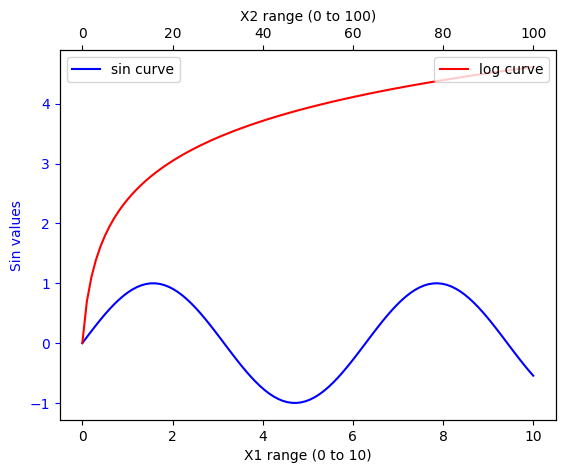

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# データの生成
x1 = np.linspace(0, 10, 100)
y1 = np.sin(x1)
x2 = np.linspace(0, 100, 100)
y2 = np.log(x2 + 1)

# グラフの作成
fig, ax1 = plt.subplots()

# 最初のグラフ（サインカーブ）
ax1.plot(x1, y1, 'b-', label='sin curve')
ax1.set_xlabel('X1 range (0 to 10)')
ax1.set_ylabel('Sin values', color='b')
ax1.tick_params('y', colors='b')

# 二つ目のグラフ（対数カーブ）のためのX軸を追加
ax2 = ax1.twiny()
ax2.plot(x2, y2, 'r-', label='log curve')
ax2.set_xlabel('X2 range (0 to 100)')
ax2.set_ylabel('Log values', color='r')
ax2.tick_params('y', colors='r')

# 凡例の追加
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# グラフの表示
plt.show()

In [23]:
x1

array([ 0.        ,  0.1010101 ,  0.2020202 ,  0.3030303 ,  0.4040404 ,
        0.50505051,  0.60606061,  0.70707071,  0.80808081,  0.90909091,
        1.01010101,  1.11111111,  1.21212121,  1.31313131,  1.41414141,
        1.51515152,  1.61616162,  1.71717172,  1.81818182,  1.91919192,
        2.02020202,  2.12121212,  2.22222222,  2.32323232,  2.42424242,
        2.52525253,  2.62626263,  2.72727273,  2.82828283,  2.92929293,
        3.03030303,  3.13131313,  3.23232323,  3.33333333,  3.43434343,
        3.53535354,  3.63636364,  3.73737374,  3.83838384,  3.93939394,
        4.04040404,  4.14141414,  4.24242424,  4.34343434,  4.44444444,
        4.54545455,  4.64646465,  4.74747475,  4.84848485,  4.94949495,
        5.05050505,  5.15151515,  5.25252525,  5.35353535,  5.45454545,
        5.55555556,  5.65656566,  5.75757576,  5.85858586,  5.95959596,
        6.06060606,  6.16161616,  6.26262626,  6.36363636,  6.46464646,
        6.56565657,  6.66666667,  6.76767677,  6.86868687,  6.96

In [24]:
x2

array([  0.        ,   1.01010101,   2.02020202,   3.03030303,
         4.04040404,   5.05050505,   6.06060606,   7.07070707,
         8.08080808,   9.09090909,  10.1010101 ,  11.11111111,
        12.12121212,  13.13131313,  14.14141414,  15.15151515,
        16.16161616,  17.17171717,  18.18181818,  19.19191919,
        20.2020202 ,  21.21212121,  22.22222222,  23.23232323,
        24.24242424,  25.25252525,  26.26262626,  27.27272727,
        28.28282828,  29.29292929,  30.3030303 ,  31.31313131,
        32.32323232,  33.33333333,  34.34343434,  35.35353535,
        36.36363636,  37.37373737,  38.38383838,  39.39393939,
        40.4040404 ,  41.41414141,  42.42424242,  43.43434343,
        44.44444444,  45.45454545,  46.46464646,  47.47474747,
        48.48484848,  49.49494949,  50.50505051,  51.51515152,
        52.52525253,  53.53535354,  54.54545455,  55.55555556,
        56.56565657,  57.57575758,  58.58585859,  59.5959596 ,
        60.60606061,  61.61616162,  62.62626263,  63.63

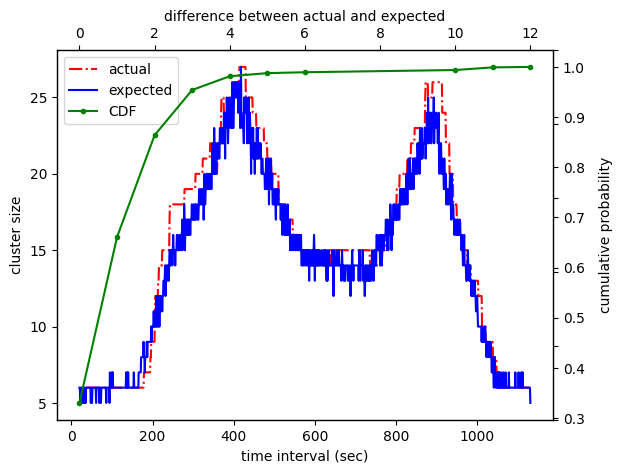

In [75]:

ax1_x1 = cdf.index
ax1_y1 = cdf.to_numpy()

ax2_x1 = [k for k, _ in enumerate(merged_02["date"])][20:]
ax2_y1 = merged_02["size"][20:]

ax2_x2 = ax2_x1
ax2_y2 = merged_02["expected_size"][20:]

# グラフの作成
fig, ax1 = plt.subplots()


ax1.plot(ax2_x1, ax2_y1, color="red", linestyle='dashdot', label='actual')
ax1.plot(ax2_x2, ax2_y2, color="blue", label='expected')
ax1.set_xlabel('time interval (sec)')
ax1.set_ylabel('cluster size')

# 新しいy軸を作成し、その後で新しいx軸を追加
ax2 = ax1.twinx().twiny()  # 新しいy軸を作成
ax2.plot(ax1_x1, ax1_y1, '.-', color="green", label='CDF')
ax2.set_xlabel('difference between actual and expected')  # 新しいx軸にラベルを設定
ax2.set_ylabel('cumulative probability')  # 新しいy軸にラベルを設定

ax3 = ax2.twinx()
ax3.set_ylabel('cumulative probability', labelpad=30)  # 新しいy軸にラベルを設定
ax3.tick_params(labelleft=False, labelright=False)

# 凡例の追加
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1 + h2, l1 + l2)

# グラフの表示
plt.show()
